## Loading dependencies

In [103]:
import os
import cv2 as cv
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import ipywidgets as widgets
from IPython.display import display, clear_output

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

%matplotlib inline

## Preprocessing

### Data paths

In [104]:
IMAGE_PATH_NO = "tumordata/no/"
IMAGE_PATH_YES = "tumordata/yes/"

Although all images seem to be in greyscale, the RGB values differ in some pixels in some images.

### Converting images to greyscale

In [105]:
grey_imgs = [[], []]
for labelimgs, i in zip([IMAGE_PATH_YES, IMAGE_PATH_NO], range(2)):
    for file in os.listdir(labelimgs):
        img = cv.imread(labelimgs + file)
        grey_imgs[i].append(cv.cvtColor(img, cv.COLOR_BGR2GRAY))

### Plotting image sizes

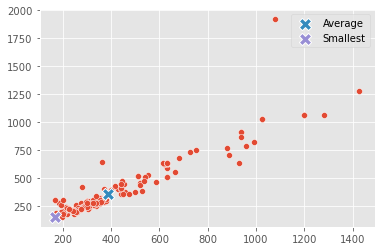

In [107]:
shapes = []
for i in range(2):
    for j in range(len(grey_imgs[i])):
        shapes.append([len(grey_imgs[i][j]), len(grey_imgs[i][j][0])])
shapes = np.array(shapes)
with plt.style.context('ggplot'):
    sn.scatterplot(x=shapes[:,0], y=shapes[:,1])
    sn.scatterplot(x=[np.average(shapes[:,0])], y=[np.average(shapes[:,1])], s=150, label='Average', marker='X')
    sn.scatterplot(x=[np.min(shapes[:,0])], y=[np.min(shapes[:,1])], s=150, label='Smallest', marker='X')

Because the dataset is relatively small and we want to reduce the required computational power, padding was not a viable solution. Instead, the images were resized to the smallest image using CV's 'INTER_AREA' interpolation method. Also, most images are of the same aspect ratio (they form a diagonal line) so they won't transform too much. 

#### Resizing images

In [98]:
t_grey_imgs = copy.deepcopy(grey_imgs)
for i in range(2):
    for j in range(len(t_grey_imgs[i])):
        t_grey_imgs[i][j] = cv.resize(t_grey_imgs[i][j], (np.min(shapes[:,0]), np.min(shapes[:,1])), interpolation = cv.INTER_AREA)

#### Plotting resized images

IntSlider(value=70, continuous_update=False, layout=Layout(height='20px', width='60.0%'), max=154)

IntSlider(value=30, continuous_update=False, layout=Layout(height='20px', width='40.0%'), max=96)

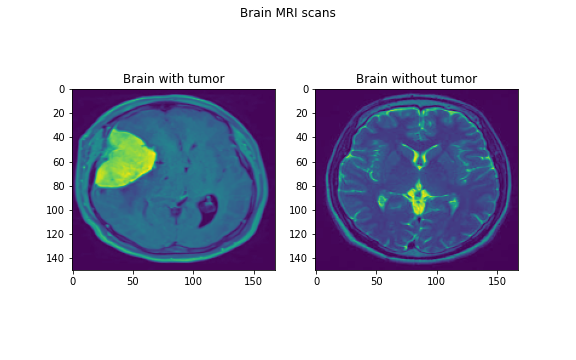

In [96]:
%matplotlib widget
import matplotlib.pyplot as plt
w1 = str(round(len(t_grey_imgs[0]) / (len(t_grey_imgs[0]) + len(t_grey_imgs[1])),1) * 100) + '%'
w2 = str(round(len(t_grey_imgs[1]) / (len(t_grey_imgs[0]) + len(t_grey_imgs[1])),1) * 100) + '%'
slider_yes = widgets.IntSlider(value=70, min=0, max=len(t_grey_imgs[0])-1, continuous_update=False, layout=widgets.Layout(width=w1, height='20px'))
slider_no = widgets.IntSlider(value=30, min=0, max=len(t_grey_imgs[1])-1, continuous_update=False, layout=widgets.Layout(width=w2, height='20px'))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 5, forward=True)
fig.suptitle('Brain MRI scans')
ax1.set_title("Brain with tumor")
ax2.set_title("Brain without tumor")
display(slider_yes)
display(slider_no)

def show_img_func_yes(i):
    i = slider_yes.value
    ax1.imshow(t_grey_imgs[0][i])

def show_img_func_no(i):
    i = slider_no.value
    ax2.imshow(t_grey_imgs[1][i])

slider_yes.observe(show_img_func_yes)
show_img_func_yes(None)

slider_no.observe(show_img_func_no)
show_img_func_no(None)

### Splitting the data

In [73]:
train_yes, test_yes = train_test_split(t_grey_imgs[0], test_size=0.2)
train_no, test_no = train_test_split(t_grey_imgs[1], test_size=0.2)
train_X = train_yes + train_no
train_y = len(train_yes)*[1] + len(train_no)*[0]
test_X = test_yes + test_no
test_y = len(test_yes)*[1] + len(test_no)*[0]

train_X, train_y = shuffle(train_X, train_y)

train_X_expanded = tf.expand_dims(train_X, axis=-1)
train_y = np.array(train_y).reshape((-1,1))

test_X_expanded = tf.expand_dims(test_X, axis=-1)
test_y = np.array(test_y).reshape((-1,1))

## Creating convolutional neural network (CNN)
This step could have been automated with a pipeline, but I wanted to visualise the intermediate feature images.

In [74]:
model = Sequential()
model.add(layers.Conv2D(3, (3,3), input_shape=(150, 168, 1)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(3, (3,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(300, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Dense(300, activation='relu', kernel_regularizer='l2'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Dense(300, activation='relu', kernel_regularizer='l2'))
model.add(layers.Dense(1, activation='sigmoid'))

In [75]:
opt = tf.keras.optimizers.Adam(
    learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 166, 3)       30        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 83, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 81, 3)         84        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 40, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4320)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               1296300   
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)              

### Visualising feature filters

In [94]:
layer_names = [layer.name for layer in model.layers]
layer_outputs = [layer.output for layer in model.layers]

feature_map_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
input_image = train_X[0]
input = input_image.reshape(-1,150,168,1)
feature_maps = feature_map_model.predict(input)

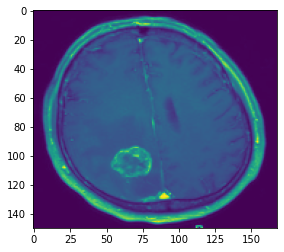

                                        ⬇


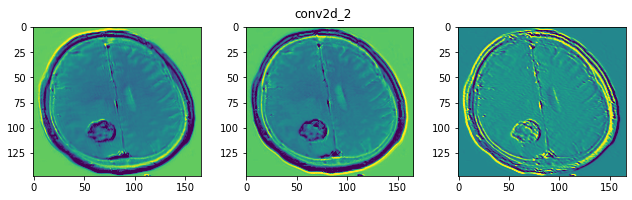

                                        ⬇


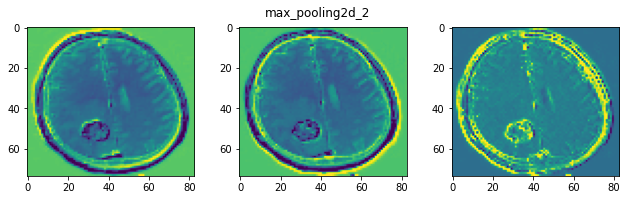

                                        ⬇


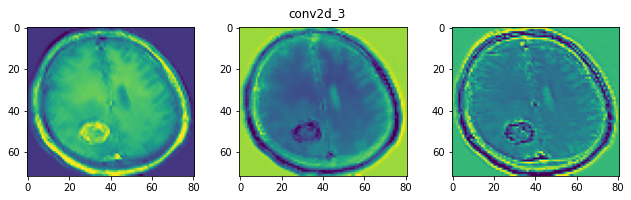

                                        ⬇


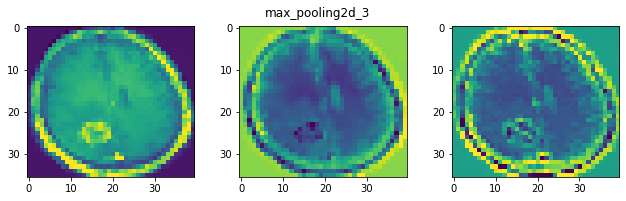

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(input_image)
plt.show()
for layer_name, feature_map in zip(layer_names, feature_maps):
    if len(feature_map.shape) == 4:
        k = feature_map.shape[-1]
        padding = ' '*k*13
        print(padding, '\u2b07')
        layer_feature_images = []
        for i in range(k):
            feature_image = feature_map[0, :, :, i]
            feature_image -= feature_image.mean()
            feature_image /= feature_image.std()
            feature_image *=  64
            feature_image += 128
            feature_image = np.clip(feature_image, 0, 255).astype('uint8')
            layer_feature_images.append(feature_image)
        fig, ax = plt.subplots(1, k, figsize=(9,4))
        fig.tight_layout()
        fig.suptitle(layer_name, y=0.85)
        for image, i in zip(layer_feature_images, range(k)):
            ax[i].imshow(image)
        plt.show()

## Training the model

In [82]:
history = model.fit(train_X_expanded, train_y, epochs=50, batch_size=15, validation_data=(test_X_expanded, test_y))

Epoch 1/50
14/14 [==============================] - 1s 106ms/step - loss: 72.2379 - accuracy: 0.5373 - val_loss: 17.0884 - val_accuracy: 0.4902
Epoch 2/50
14/14 [==============================] - 1s 78ms/step - loss: 19.3953 - accuracy: 0.6617 - val_loss: 8.9624 - val_accuracy: 0.7843
Epoch 3/50
14/14 [==============================] - 1s 83ms/step - loss: 13.3169 - accuracy: 0.6418 - val_loss: 7.7351 - val_accuracy: 0.7647
Epoch 4/50
14/14 [==============================] - 1s 77ms/step - loss: 10.8282 - accuracy: 0.7164 - val_loss: 6.2077 - val_accuracy: 0.8235
Epoch 5/50
14/14 [==============================] - 1s 74ms/step - loss: 8.9108 - accuracy: 0.7065 - val_loss: 5.1781 - val_accuracy: 0.8235
Epoch 6/50
14/14 [==============================] - 1s 76ms/step - loss: 7.8315 - accuracy: 0.7662 - val_loss: 5.6031 - val_accuracy: 0.8627
Epoch 7/50
14/14 [==============================] - 1s 75ms/step - loss: 6.2407 - accuracy: 0.8109 - val_loss: 5.3221 - val_accuracy: 0.9020
Epoch 8

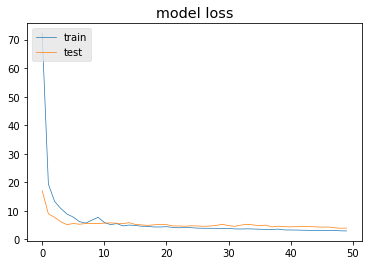

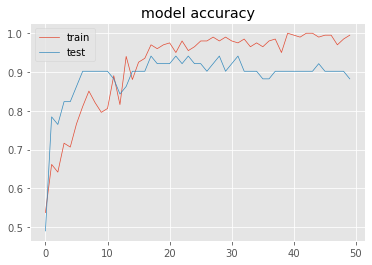

In [84]:
fig, ax = plt.subplots()

with plt.style.context('ggplot'):
    plt.plot(history.history['loss'], linewidth=0.7)
    plt.plot(history.history['val_loss'], linewidth=0.7)
    plt.title('model loss')
    plt.legend(['train', 'test'], loc='upper left')
plt.show()

with plt.style.context('ggplot'):
    plt.plot(history.history['accuracy'], linewidth=0.7)
    plt.plot(history.history['val_accuracy'], linewidth=0.7)
    plt.title('model accuracy')
    plt.legend(['train', 'test'], loc='upper left')

## Plotting false negatives and false positives

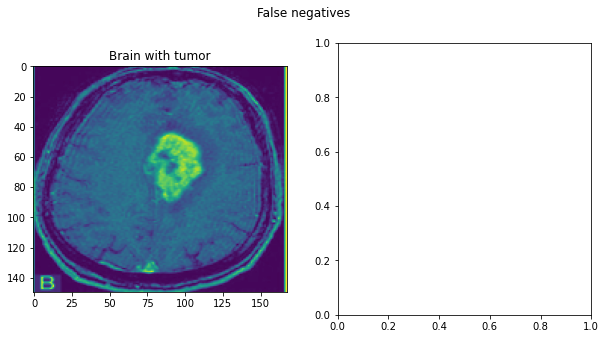

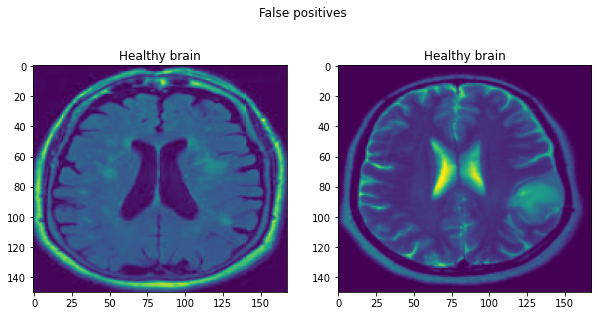

In [93]:
test_y_pred = model.predict(test_X_expanded)
test_y_pred = (test_y_pred > 0.5).astype(int)

false_negatives, false_positives = [], []
for pred_label, true_label, i in zip(test_y_pred, test_y, range(len(test_y))):
    if pred_label == 1 and true_label == 0:
        false_positives.append(i)
    if pred_label == 0 and true_label == 1:
        false_negatives.append(i)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5, forward=True)
fig.suptitle('False negatives')
if len(false_negatives) < 2:
    for false_neg, i in zip(false_negatives, range(len(false_negatives))):
        ax[i].imshow(test_X[false_neg])
        ax[i].set_title('Brain with tumor')
else:
    false_negatives_samples = np.random.choice(false_negatives, 2, replace=False)
    ax[0].imshow(test_X[false_negatives_samples[0]])
    ax[0].set_title('Brain with tumor')
    ax[1].imshow(test_X[false_negatives_samples[1]])
    ax[1].set_title('Brain with tumor')

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5, forward=True)
fig.suptitle('False positives')
if len(false_positives) < 2:
    for false_pos, i in zip(false_positives, range(len(false_positives))):
        ax[i].imshow(test_X[false_pos])
        ax[i].set_title('Healthy brain')
else:
    false_positives_samples = np.random.choice(false_positives, 2, replace=False)
    ax[0].imshow(test_X[false_positives_samples[0]])
    ax[0].set_title('Healthy brain')
    ax[1].imshow(test_X[false_positives_samples[1]])
    ax[1].set_title('Healthy brain')

Some of the misclassified images show it is not unreasonable why the network got confused. Some of the images might even have been labeled falsely. Since the images were webscraped from Google images, having an expert validate the correctness of the labels might help the model to achieve a higher accuracy.

## Seeing the model in action
Given are four people with their MRI scan, two of which have a tumor in their brain and two of which do not.

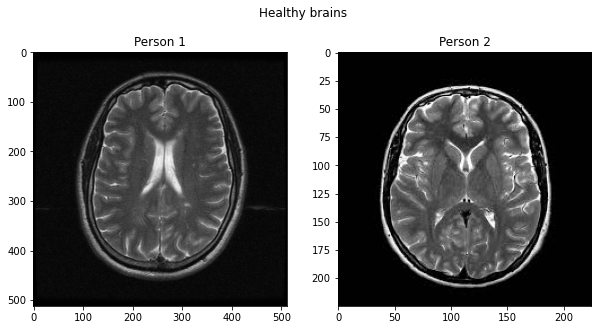

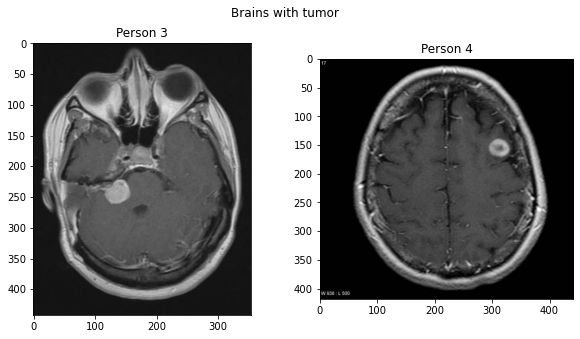

In [87]:
img1 = cv.imread("tumordata/healthy_brain.jpg")
img2 = cv.imread("tumordata/healthy_brain2.jpg")
img3 = cv.imread("tumordata/sick_brain.jpeg")
img4 = cv.imread("tumordata/sick_brain2.jpeg")

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5, forward=True)

ax1.imshow(img1)
ax1.set_title('Person 1')
ax2.imshow(img2)
ax2.set_title('Person 2')
fig.suptitle('Healthy brains')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5, forward=True)

ax1.imshow(img3)
ax1.set_title('Person 3')
ax2.imshow(img4)
ax2.set_title('Person 4')
fig.suptitle('Brains with tumor');

#### Checking whether the images are new

In [89]:
no_imgs = [img1, img2]
yes_imgs = [img3, img4]

for img in no_imgs:
    grey_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    for shape, i in zip(shapes[155:], range(len(shapes[155:]))):
        if set(shape) == set(grey_img.shape):
            if (grey_img == grey_imgs[1][i]).all():
                plt.imshow(grey_imgs[1][i])

for img in yes_imgs:
    grey_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    for shape, i in zip(shapes[:155], range(len(shapes[:155]))):
        if set(shape) == set(grey_img.shape):
            if (grey_img == grey_imgs[0][i]).all():
                plt.imshow(grey_imgs[0][i])

There are no images plotted, so the new images are not contained in the training and test data.

#### Predicting the state of the brains

In [91]:
# ---This makes sure the cell can be re-run---
# img1 = cv.imread("tumordata/healthy_brain.jpg")
# img2 = cv.imread("tumordata/healthy_brain2.jpg")
# img3 = cv.imread("tumordata/sick_brain.jpeg")
# img4 = cv.imread("tumordata/sick_brain2.jpeg")
# --------------------------------------------
imgs = [img1, img2, img3, img4]
for img, person_id in zip(imgs, range(len(imgs))):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.resize(img, (np.min(shapes[:,0]), np.min(shapes[:,1])), interpolation = cv.INTER_AREA)
    img = tf.expand_dims(img, axis=-1)
    res = model.predict(np.array([img]))[0][0]
    if res > 0.5:
        print("Person", person_id+1,"probably has a brain tumor with a confidence of:", res)
    else:
        print("Person", person_id+1,"probably doesn't have a brain tumor with a confidence of:", 1-res)

Person 1 probably doesn't have a brain tumor with a confidence of: 0.9999999981713295
Person 2 probably doesn't have a brain tumor with a confidence of: 0.9999116228937055
Person 3 probably has a brain tumor with a confidence of: 0.99126667
Person 4 probably has a brain tumor with a confidence of: 0.9720664
